In [5]:
#Packages:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from camera_matrix import camera_matrix
import time
import seaborn as sns
import matplotlib.patches as mpatches

In [6]:
def save_BW_img(cap):
    image= []
    while True:
  # Lire l'image suivante de la vidéo
        ret, frame = cap.read()

  # Vérifier si la fin de la vidéo a été atteinte
        if not ret:
            break

  # Convertir l'image en noir et blanc
        img_gray= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        image.append(img_gray)
    cv2.destroyAllWindows()
    cap.release() 
    return image

In [7]:
def save_half_frames(images):
    selected_images = []
    for i in range(len(images)):
        if i % 2 == 0:
            selected_images.append(images[i])
    return selected_images

In [8]:
# Read a sequence of 2 stereoscopic images, synchronized (frame 107 to 131 for video 1, frame 45 to 69 for video 2)
#cap0 = cv2.VideoCapture("/Users/nilsmanni/Desktop/MA2/design_project/Design-Project/vid1_dx.MP4")
#cap0 = cv2.VideoCapture("/Users/nilsmanni/Desktop/MA2/design_project/GX010031.MP4")
cap0 = cv2.VideoCapture("/Users/nilsmanni/Desktop/MA2/design_project/GX010056.MP4")
#cap1 = cv2.VideoCapture("/Users/nilsmanni/Desktop/MA2/design_project/Design-Project/vid1_sx.MP4")

dx_images = save_BW_img(cap0)
dx_images = save_half_frames(dx_images)


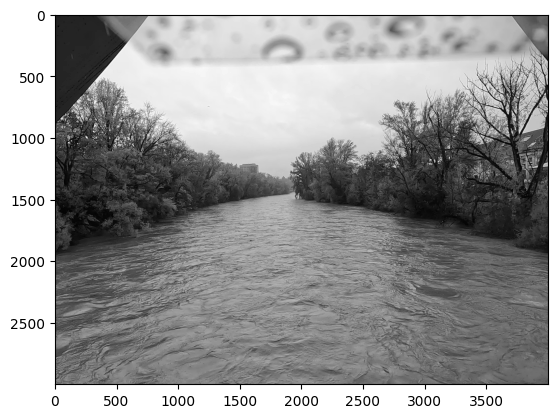

In [9]:
# Show two synchronized images
from PIL import Image
import matplotlib.pyplot as plt

image = dx_images[0]

plt.imshow(image, cmap='gray')

In [10]:
# Define the y-axis range
start_y = 2000
end_y = 2750

# define the x-axis range
start_x = 0
end_x = 4000
# Define the size of the stripe
stripe_height = end_y - start_y
stripe_width = end_x - start_x

dx_stripes = []

# Loop through the images and select the stripe for each image
for img in dx_images:
    # Convert the image to a numpy array
    img_array = np.array(img)

    # Select the stripe using array slicing
    selected_stripe = img_array[start_y:end_y, start_x:end_x]

    # Append the selected stripe to the list
    dx_stripes.append(selected_stripe)

# Now, 'stripes' is a list containing the selected stripes from each image

[[[1023  174]]

 [[1862  452]]

 [[1259  123]]

 [[1163  262]]

 [[ 757  345]]

 [[ 869   51]]

 [[ 933  324]]

 [[1022  322]]

 [[1283  734]]

 [[1636   90]]

 [[2604  115]]

 [[ 481  499]]

 [[1110  139]]

 [[1298   11]]

 [[2092    6]]

 [[1517   84]]

 [[2761  229]]

 [[2189  172]]

 [[ 974  234]]

 [[1508  422]]

 [[2824   35]]

 [[2966   89]]

 [[1172   59]]

 [[2901  115]]

 [[3014  389]]

 [[ 927  112]]

 [[2498  197]]

 [[ 540  236]]

 [[ 627   64]]

 [[1784   93]]

 [[1424  148]]

 [[2692  189]]

 [[1965   20]]

 [[2662  329]]

 [[1201  618]]

 [[ 558   19]]

 [[ 751  443]]

 [[1604  444]]

 [[2089  194]]

 [[2653  463]]

 [[2647   10]]

 [[ 283  286]]

 [[2016  470]]

 [[2579  452]]

 [[1875  160]]]


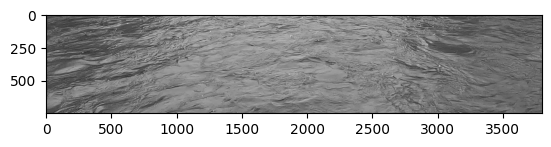

(<matplotlib.image.AxesImage at 0x3199f8a00>, None)

In [22]:
nb_points = 45
def keypoint(nb_points, image):
    corners = cv2.goodFeaturesToTrack(image, nb_points,0.1,70)
    corners = np.intp(corners)
    return corners # les paires de coordonnées de chaque keypoints

corners = keypoint(nb_points, dx_stripes[0])
print(corners)
img_circles = dx_stripes[0].copy()

for i in corners:
 x,y = i.ravel()
 cv2.circle(img_circles,(x,y),3,255,-1)
 
plt.imshow(img_circles, cmap='gray'),plt.show()

In [12]:
def NCC_window(x,y, image): # normalized cross correlation window of 9x9 around our pixel of 
    # Do not forget that if x0-4 or x0+5 is out of the image, we will not take into account this tracking point. 
    #NCC = image[y-4:y+5, x-4:x+5] # rows and columns are switched in the image ( image size is 750x1500)
    NCC = image[y-18:y+19, x-18:x+19]
    return NCC

In [15]:
def tracking(x0,y0,image, NCC):
    match = 0
    x1 = 0
    y1 = 0
    for x in range(x0-14, x0+14): 
        for y in range(y0-14, y0+14):
            img_comp = NCC_window(x,y,image)
            res = cv2.matchTemplate(img_comp,NCC, cv2.TM_CCORR_NORMED)
            if np.max(res) > match: 
                match = np.max(res)
                x1 = x
                y1 = y
    return(x1, y1)

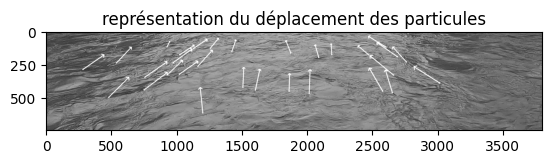

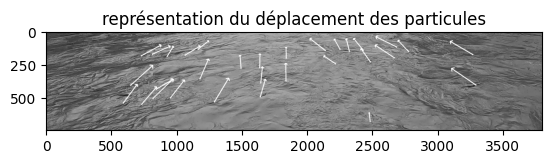

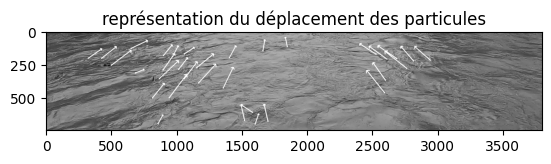

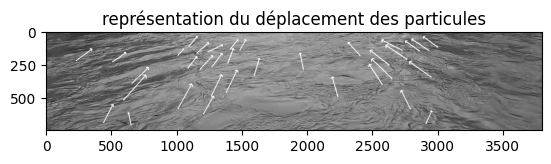

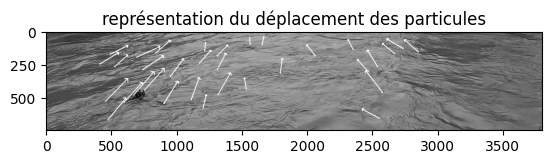

         x0     y0      x1     y1  direction      length
157   493.0  169.0   628.0  103.0  -1.116077  150.269757
158  1216.0  143.0  1222.0   78.0  -0.092047   65.276336
159  2063.0  181.0  1996.0   97.0   0.673287  107.447662
160  1204.0  579.0  1227.0  478.0  -0.223905  103.585713
161  2468.0  301.0  2384.0  209.0   0.739975  124.579292


In [16]:
stats = pd.DataFrame()

for img_nb in range(0, len(dx_stripes)):
    if img_nb % 30 == 0 and img_nb + 16 < len(dx_stripes): # la deuxieme condition est nécessaire pour pouvoir analyser les images jusqu'à la fin de la video
        corners = keypoint(nb_points, dx_stripes[img_nb])
        coord_track = corners[:,0,:2].ravel().reshape(nb_points,2)
        displacement = np.zeros((nb_points,15,2))
        point_i = 0
        point_delete = []
        for x,y in coord_track: 
            for i in range(img_nb + 1, img_nb + 16):
                if x< 32 or x > stripe_width-32 or y < 32 or y > stripe_height-32: 
                    #stock les points à enlever
                    point_delete= np.append(point_delete, point_i)
                    break #skip au prochain point
                NCC = NCC_window(x,y, dx_stripes[i-1])
                displacement[point_i, i-1-img_nb ,:]= x,y
                x,y = tracking(x,y, dx_stripes[i], NCC)
            point_i += 1
        point_delete= point_delete.astype(int)
        displacement = np.delete(displacement,point_delete,0 )
        img_circles = dx_stripes[img_nb].copy()

        direction = []
        length = []
        for j in range(displacement.shape[0]):
            x0,y0 = displacement[j,0,:]
            x1,y1 = displacement[j,14,:]
            # recupere angle et taille des vecteurs

            if y1-y0 == 0: #trouver le moyen d'élimier les vecteurs ou on divise par 0
                angle = np.nan
                intensity = np.nan
            else: 
                angle = np.arctan((x1-x0)/(y1-y0))
                intensity = np.sqrt((x1-x0)*(x1-x0) + (y1-y0)*(y1-y0))
            
            direction = np.append(direction, angle)
            length= np.append(length, intensity)

            # représente les vecteurs sur les images
            cv2.circle(img_circles,(int(x0),int(y0)),5,255,-1)
            cv2.circle(img_circles,(int(x1),int(y1)),5,(70,255,212),-1)
            cv2.arrowedLine(img_circles, (int(x0),int(y0)), (int(x1),int(y1)), 255, 6)

        x0 = displacement[:, 0, 0]
        y0 = displacement[:, 0, 1]
        x1 = displacement[:, 14, 0]
        y1 = displacement[:, 14, 1]

        stats_temp = pd.DataFrame({
            'x0': x0,
            'y0': y0,
            'x1': x1,
            'y1': y1,
            'direction': direction,
            'length': length
        })
        stats = pd.concat([stats, stats_temp], ignore_index=True)
        plt.title('représentation du déplacement des particules')
        plt.imshow(img_circles, cmap = 'gray'),plt.show()

print(stats.tail())

Comment réduire la std? 

    - prendre en compte les jeux de luminosité

    - The distance thresholds canbe roughly approximated when the image scale and the range of expected river ﬂow velocity are known. In this study, the minimum and maximum distance parameters are set to 0.1and 10 pixels, respectively.

    - considers the directional ﬂow behaviour of the feature with a steadiness parameter. Therefore,directions of sub-tracks (from frame to frame) are analysed for each track. Tracks are excluded when the standard devi-ation is above a deﬁned threshold (30° in this study). The idea is that river observations are performed during nearly uniform ﬂow conditions. Thus, high frequencies of changes in ﬂow directions within a track indicate measurement errors and should be ﬁltered. In addition to this steadiness parameter, the range of all sub-track directions is also considered as a measure of the ﬂow behaviour. If the range is above adeﬁned threshold, the track will be excluded (here 120°).

    - prendre les angles par rapport au point de fuite. 

    - moyenene des vitesses transversales == 0

    - prendre des fenetres NCC plus grande (entre 30 et 50 pixels) ?

In [17]:
display(stats[['direction', 'length']].describe()) #cv2.TM_CCOEFF_NORMED

,direction,length
count,162.000000,162.000000
mean,-0.145248,149.232246
std,0.718098,45.469008
min,-1.200625,46.957428
25%,-0.741741,115.143054
50%,-0.378961,148.988240
75%,0.572981,180.215919
max,1.112161,256.363024


In [11]:
display(stats[['direction', 'length']].describe()) #cv2.TM_SQDIFF_NORMED

,direction,length
count,376.000000,376.000000
mean,-0.122770,82.052194
std,0.730422,24.050197
min,-1.190290,34.000000
25%,-0.765493,60.495569
50%,-0.355658,83.677940
75%,0.655103,100.837470
max,1.212026,133.734812


In [12]:
display(stats[['direction', 'length']].describe()) #cv2.TM_CCORR_NORMED

,direction,length
count,376.000000,376.000000
mean,-0.122770,82.052194
std,0.730422,24.050197
min,-1.190290,34.000000
25%,-0.765493,60.495569
50%,-0.355658,83.677940
75%,0.655103,100.837470
max,1.212026,133.734812


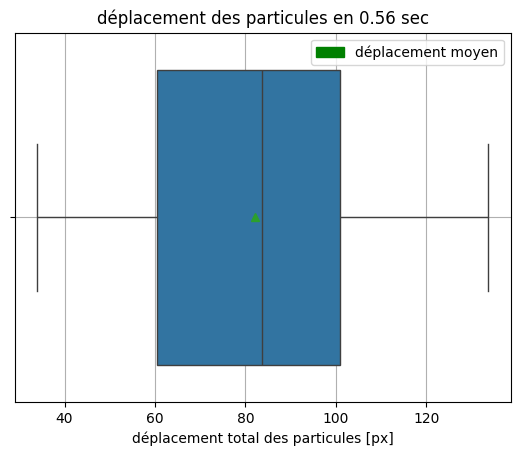

In [13]:
#boxplot= stats.boxplot(column = ['vertical_anlge'])
sns.boxplot(x="length", showmeans=True, data=stats)
#sns.despine(bottom=True)
mean_patch = mpatches.Patch(color='green', label='déplacement moyen')
plt.legend(handles=[mean_patch], loc='upper right')
plt.xlabel("déplacement total des particules [px]")
plt.title("déplacement des particules en 0.56 sec")
plt.grid(True)
plt.show()